In [1]:
import os
import sys

seed = 0
os.environ['PYTHONHASSEED'] = str(seed)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random

from tensorflow.random import set_seed

In [3]:
# Set seed
random.seed(seed)
np.random.seed(seed)
set_seed(seed)

In [6]:
# Add modules path
module_path = os.path.abspath('../..')
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
from src.data_reader import DataReader
from src.model_evaluation import evaluate_mlp_multiple_splits
from src.plotting import plot_loss_curves, plot_prediction_error, plot_rul_confidence_interval

In [8]:
# Set input and output paths
data_path = '../data/N-CMAPSS_DS02-006.h5'
model_path = '../models/mlp1_no_preproc'
output_path = '../results/plots/mlp1_no_preproc'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [9]:
# Read dataset
data_reader = DataReader()

start_time = time.process_time()  
data_reader.load_dataset(data_path, load_train=False, load_test=True)
print("Operation time (sec): " , (time.process_time() - start_time))

if data_reader.train_set is not None:
    print("Train set shape: " + str(data_reader.train_set.shape))
    
if data_reader.test_set is not None:   
    print("Test set shape: " + str(data_reader.test_set.shape))

Operation time (sec):  0.734375
Test set shape: (1253743, 47)


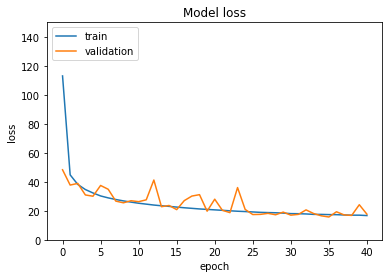

Test set:
MSE: 68.15
RMSE: 8.26
CMAPSS score: 1.84



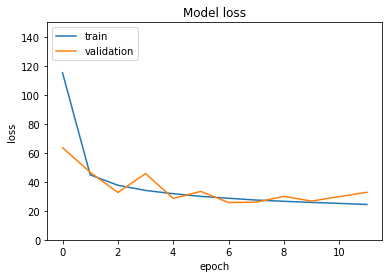

Test set:
MSE: 57.54
RMSE: 7.59
CMAPSS score: 1.74



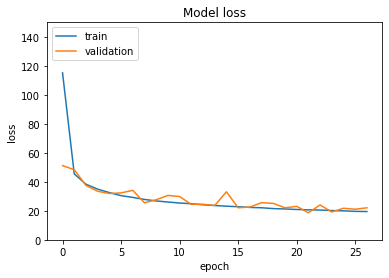

Test set:
MSE: 69.95
RMSE: 8.36
CMAPSS score: 1.85

MSE: mean = 65.21   stddev = 5.47
RMSE: mean = 8.07   stddev = 0.34
CMAPSS: mean = 1.81   stddev = 0.05


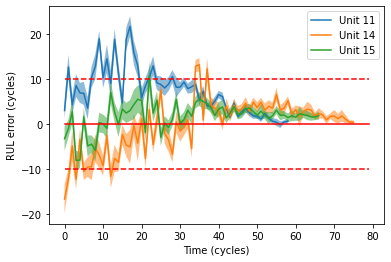

In [18]:
NUM_TRIALS = 3
TRAIN_RESULTS_PATH = model_path

# Prepare data
test_set = data_reader.test_set
y_test = test_set['RUL']
x_test = test_set.drop(['RUL'], axis=1)

selected_columns = data_reader.column_names.w_cols + data_reader.column_names.x_s_cols
x_test = x_test[selected_columns]

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Load and evaluate models
results = evaluate_mlp_multiple_splits(x_test, y_test, NUM_TRIALS, TRAIN_RESULTS_PATH, 
                                       plot_loss=True)

predicted_rul_mean = np.array(results.prediction_vals).mean(axis=0)
predicted_rul_std = np.array(results.prediction_vals).std(axis=0)

# Plot
prediction_errors = []
for i in range(len(results.prediction_vals)):
    prediction_errors.append(results.prediction_vals[i] - y_test)
    
err_mean = np.array(prediction_errors).mean(axis=0)
err_std = np.array(prediction_errors).std(axis=0)
    
rul_eval_dict = {'unit': test_set['unit'],
                'cycle': test_set['cycle'],
                'err_mean': err_mean,
                'err_std': err_std,
                'actual_RUL': test_set['RUL'],
                'predicted_RUL_mean': predicted_rul_mean,
                'predicted_RUL_std': predicted_rul_std}
rul_eval = pd.DataFrame(rul_eval_dict)

plot_prediction_error(rul_eval, output_path=os.path.join(output_path, "rul_error.png"))

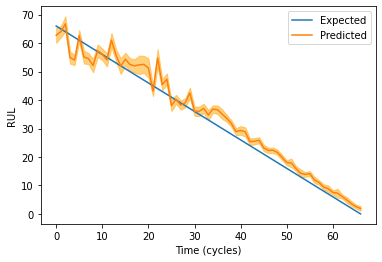

In [21]:
TEST_UNIT = 15

rul_eval_test_unit = rul_eval[rul_eval.unit == TEST_UNIT]
rul_eval_mean = rul_eval_test_unit.groupby('cycle').mean()

plot_rul_confidence_interval(rul_eval_mean, 
                             output_path=os.path.join(output_path, f"rul_unit_{TEST_UNIT}.png"))